BackgroundSubtractorMOG2 usa um método para modelar cada pixel de fundo por uma mistura de distribuições K Gaussianas
Os pesos da mistura representam as proporções de tempo que essas cores permanecem na cena. 
As cores de fundo prováveis são as que ficam mais longas e mais estáticas.

Obs: Dê Alt + Tab para ir para janela de reprodução do vídeo

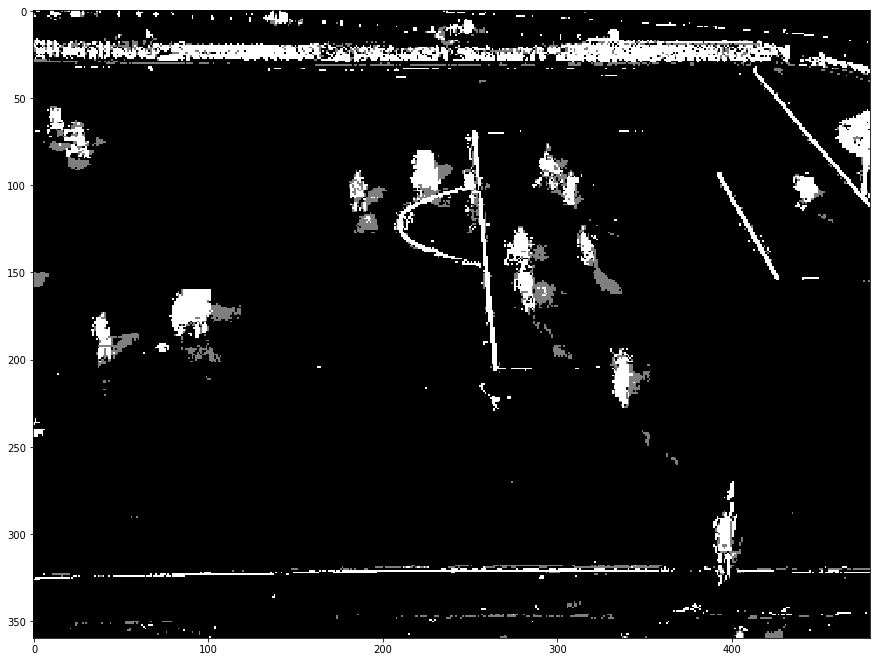

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from time import sleep

def show_img(img, size=(15, 15)):
    plt.figure(figsize=size)
    
    if len(img.shape) == 2:
        plt.gray()
        plt.imshow(img)
    else:
        plt.imshow(img[:, :, ::-1])
    plt.show()


def play_video(video_path, f = lambda x: x, frames=-1, window_name='Video', fps=30, **kwargs):
    vidcap = cv2.VideoCapture(video_path)
    
    if vidcap.isOpened():
        length = vidcap.get(cv2.CAP_PROP_FRAME_COUNT) if frames == -1 else frames
        success,img = vidcap.read()

        old_frame, k, counter = img, -1, 0
        while success and counter != frames and k != ord('q'):
            old_frame = img
            cv2.imshow(window_name, f(img, **kwargs))

            sleep(1/fps)
            success, img = vidcap.read()
            k = cv2.waitKey(1)
            counter += 1

            pos = int(counter/length * 90)
            print('Playing video: ' + '[' + pos*'o' + '>' + ' '*(90 - pos) + ']', end='\r')

        cv2.destroyAllWindows()
        vidcap.release()
    else:
        print("Couldn't open the video!")
    
    return f(old_frame, **kwargs)


img = play_video('sample_41.mp4', cv2.createBackgroundSubtractorMOG2().apply, 200)

show_img(img)

img = play_video('sample_41.mp4', cv2.createBackgroundSubtractorMOG2().apply, 300)

show_img(img)

Fluxo óptico é o padrão de movimento aparente de objetos de imagem entre dois quadros consecutivos causados pelo movimento do objeto ou da câmera. É um campo vetorial 2D onde cada vetor é um vetor de deslocamento mostrando o movimento dos pontos do primeiro quadro ao segundo. 


In [25]:
import numpy as np
import cv2

cap = cv2.VideoCapture('sample_47.mp4')

t_params = dict( maxCorners = 30,
                       qualityLevel = 0.01,
                       minDistance = 15,
                       blockSize = 7 )

lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

color = np.random.randint(0,255,(100,3))

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **t_params)

mask = np.zeros_like(old_frame)

while(1):
    sucess,frame = cap.read()
    
    if not sucess:
        break
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    p1, status, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    good_new = p1[status==1]
    good_old = p0[status==1]

    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

